In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# --- 1. 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

# --- 2. 提取和加载数据集 ---
BATCH_SIZE = 128 # VAE usually uses larger batch sizes

# 使用 '../T1_generative/data'，这将存储在 GNNs/T1_generative/data
train_dataset = torchvision.datasets.MNIST(
    root='../T1_generative/data', train=True, transform=transform, download=True
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

# (We usually don't need a test set for VAE unless for evaluation purposes)

print("M1 数据准备完毕。")
print(f"训练集批次数: {len(train_loader)}")

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../T1_generative/data/MNIST/raw/train-images-idx3-ubyte.gz to ../T1_generative/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../T1_generative/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../T1_generative/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../T1_generative/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../T1_generative/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ../T1_generative/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../T1_generative/data/MNIST/raw

M1 数据准备完毕。
训练集批次数: 469


In [2]:
# --- 1. 检查并定义计算设备 ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("使用 Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("使用 CPU")

# --- 2. 定义 VAE 模型 ---


# (我们使用一个简单的卷积 VAE)

LATENT_DIM = 20 # 潜空间的维度

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # --- 编码器 ---
        # 1x28x28 -> 32x14x14 -> 64x7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # -> 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> 64x7x7
            nn.ReLU(),
            nn.Flatten() # -> 64*7*7 = 3136
        )

        # 潜空间层
        self.fc_mu = nn.Linear(64*7*7, LATENT_DIM)
        self.fc_logvar = nn.Linear(64*7*7, LATENT_DIM)

        # --- 解码器 ---
        self.decoder_fc = nn.Linear(LATENT_DIM, 64*7*7)

        # 64x7x7 -> 32x14x14 -> 1x28x28
        self.decoder = nn.Sequential(
            # (需要 un-flatten)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # -> 1x28x28
            nn.Tanh() # 关键：将输出压缩到 [-1, 1] 范围，以匹配 M0 的数据归一化
        )

    def reparameterize(self, mu, logvar):
        """重参数化技巧"""
        std = torch.exp(0.5 * logvar) # sigma = exp(log(sigma^2)/2)
        eps = torch.randn_like(std)   # eps ~ N(0, 1)
        return mu + eps * std         # z = mu + sigma * eps

    def forward(self, x):
        # 编码
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # 采样
        z = self.reparameterize(mu, logvar)

        # 解码
        h_decoded = self.decoder_fc(z)
        h_decoded = h_decoded.view(-1, 64, 7, 7) # Un-flatten
        x_recon = self.decoder(h_decoded)

        return x_recon, mu, logvar

print("VAE 模型类已定义。")

使用 Apple Silicon GPU (MPS)
VAE 模型类已定义。


In [3]:
# --- 1. 实例化模型，损失函数和优化器 ---
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 2. 定义自定义损失函数 ---
def vae_loss_function(x_recon, x, mu, logvar):
    # 1. 重建损失 (Reconstruction Loss)
    #    我们使用均方误差 (MSE)，因为它与 Tanh 输出和 [-1, 1] 归一化兼容
    recon_loss = nn.MSELoss(reduction='sum')(x_recon, x)

    # 2. KL 散度 (Kullback-Leibler Divergence)
    #    D_KL( Q(z|x) || P(z) )
    #    P(z) is N(0, 1)
    #    公式: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

# --- 3. 核心引擎 (训练循环) ---
NUM_EPOCHS = 10 # VAE 需要更长时间的训练
print(f"--- 开始训练 VAE，共 {NUM_EPOCHS} 个周期 ---")

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_idx, (inputs, _) in enumerate(train_loader): # (我们不需要标签)
        inputs = inputs.to(device)

        # === 核心引擎 5 步骤 (已修改) ===

        # 1. 清空梯度 (zero_grad)
        optimizer.zero_grad()

        # 2. 前向传播 (forward)
        #    f(x; theta) -> (x_recon, mu, logvar)
        x_recon, mu, logvar = model(inputs)

        # 3. 计算损失 (loss)
        #    L( (x_recon, mu, logvar), inputs )
        loss = vae_loss_function(x_recon, inputs, mu, logvar)

        # 4. 反向传播 (backward)
        loss.backward()

        # 5. 优化器步骤 (step)
        optimizer.step()
        # ==========================

        total_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], 批次 [{batch_idx+1}/{len(train_loader)}], 平均损失: {total_loss / ((batch_idx+1) * BATCH_SIZE):.4f}')

    avg_loss = total_loss / len(train_dataset)
    print(f'--- Epoch {epoch+1} 完毕 --- 平均损失: {avg_loss:.4f} ---')

print('--- VAE 训练完成 ---')

--- 开始训练 VAE，共 10 个周期 ---
Epoch [1/10], 批次 [100/469], 平均损失: 235.5975
Epoch [1/10], 批次 [200/469], 平均损失: 173.9141
Epoch [1/10], 批次 [300/469], 平均损失: 147.1240
Epoch [1/10], 批次 [400/469], 平均损失: 132.0624
--- Epoch 1 完毕 --- 平均损失: 124.9488 ---
Epoch [2/10], 批次 [100/469], 平均损失: 80.8665
Epoch [2/10], 批次 [200/469], 平均损失: 79.8400
Epoch [2/10], 批次 [300/469], 平均损失: 78.8327
Epoch [2/10], 批次 [400/469], 平均损失: 78.0321
--- Epoch 2 完毕 --- 平均损失: 77.4319 ---
Epoch [3/10], 批次 [100/469], 平均损失: 73.3621
Epoch [3/10], 批次 [200/469], 平均损失: 72.7363
Epoch [3/10], 批次 [300/469], 平均损失: 72.3391
Epoch [3/10], 批次 [400/469], 平均损失: 71.8990
--- Epoch 3 完毕 --- 平均损失: 71.7456 ---
Epoch [4/10], 批次 [100/469], 平均损失: 69.6589
Epoch [4/10], 批次 [200/469], 平均损失: 69.4017
Epoch [4/10], 批次 [300/469], 平均损失: 69.2977
Epoch [4/10], 批次 [400/469], 平均损失: 69.1171
--- Epoch 4 完毕 --- 平均损失: 68.9663 ---
Epoch [5/10], 批次 [100/469], 平均损失: 67.8436
Epoch [5/10], 批次 [200/469], 平均损失: 67.7023
Epoch [5/10], 批次 [300/469], 平均损失: 67.5131
Epoch [5/10], 批次 [400/4

生成数据

Matplotlib is building the font cache; this may take a moment.


--- 开始从潜空间生成图像 ---


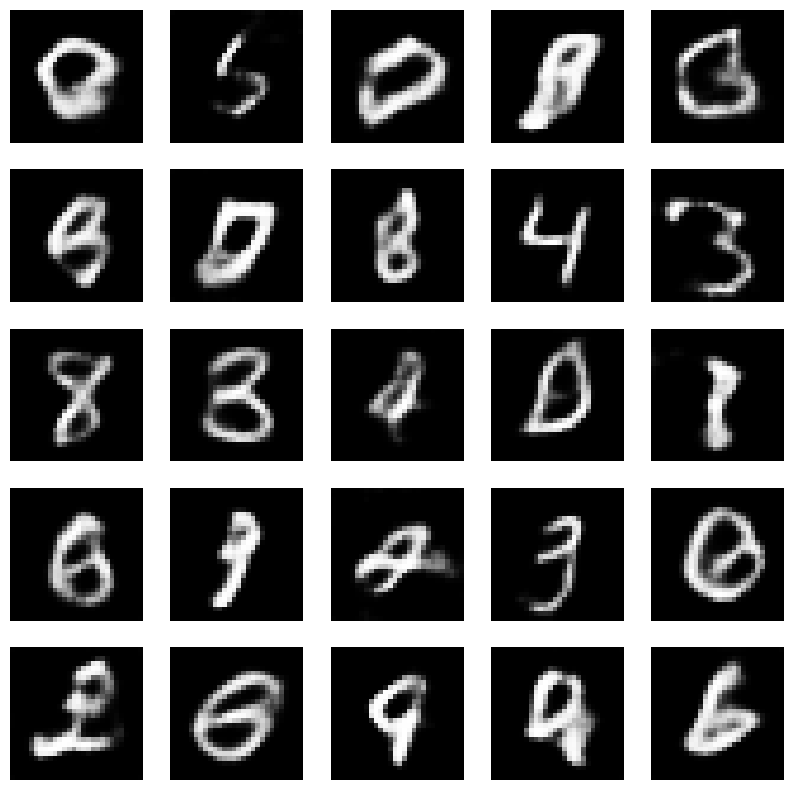

生成完毕。


In [4]:
import matplotlib.pyplot as plt
import numpy as np

print("--- 开始从潜空间生成图像 ---")

# 1. 确保安装了 matplotlib
#    在 VS Code 终端运行: (GNNS) pip install matplotlib

# 2. 将模型设置为评估模式
model.eval()

# 3. 准备绘图
plt.figure(figsize=(10, 10))

# 4. 关闭梯度计算
with torch.no_grad():
    for i in range(25): # 生成 25 张图像

        # a. 从 N(0, 1) 随机采样一个 z 向量
        #    (LATENT_DIM 是 20)
        z_sample = torch.randn(1, LATENT_DIM).to(device)

        # b. 通过解码器运行 z
        #    z -> h_decoded -> x_recon
        h_decoded = model.decoder_fc(z_sample)
        h_decoded = h_decoded.view(-1, 64, 7, 7) # Un-flatten
        generated_image = model.decoder(h_decoded)

        # c. 将图像移回 CPU 并格式化以便绘图
        #    (B, C, H, W) -> (H, W, C)
        img_to_plot = generated_image.cpu().squeeze().numpy()

        # d. 绘制子图
        plt.subplot(5, 5, i + 1)
        # (记住我们归一化到了 [-1, 1], 所以要反归一化到 [0, 1] 来显示)
        plt.imshow((img_to_plot * 0.5) + 0.5, cmap='gray')
        plt.axis('off')

plt.show()
print("生成完毕。")